# **Advanced Lane Finding Project** 
***
The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


[//]: # (Image References)

[image1]: ./examples/undistort_output.png "Undistorted"
[image2]: ./test_images/test1.jpg "Road Transformed"
[image3]: ./examples/binary_combo_example.jpg "Binary Example"
[image4]: ./examples/warped_straight_lines.jpg "Warp Example"
[image5]: ./examples/color_fit_lines.jpg "Fit Visual"
[image6]: ./examples/example_output.jpg "Output"
[video1]: ./project_video.mp4 "Video"

## [Rubric](https://review.udacity.com/#!/rubrics/571/view) Points
###Here I will consider the rubric points individually and describe how I addressed each point in my implementation.  


### Writeup / README

#### 1. Provide a Writeup / README that includes all the rubric points and how you addressed each one.  

This is the Writeup / README file.

### Camera Calibration

#### 1. Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.

The code for this step is contained in the first code cell of the IPython notebook.  

I start by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image.  Thus, `objp` is just a replicated array of coordinates, and `objpoints` will be appended with a copy of it every time I successfully detect all chessboard corners in a test image.  `imgpoints` will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.  

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

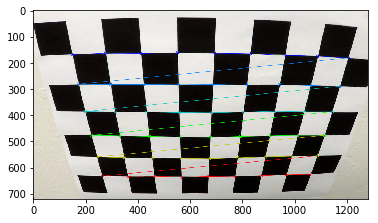

In [2]:
# Read in a calibration image
img = mpimg.imread('./camera_cal/calibration2.jpg')
plt.imshow(img)

# Arrays to store object points and image points from all the images

xPoints = 9
yPoints = 6

objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane

# Prepare object points, like (0, 0, 0), (1, 0, 0), (2, 0, 0) ...,(7, 5 , 0)
objp = np.zeros((yPoints*xPoints,3), np.float32)
objp[:,:2] = np.mgrid[0:xPoints, 0:yPoints].T.reshape(-1,2) #x,  y coordinates

# Convert image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Find the chessboard corners
ret, corners = cv2.findChessboardCorners(gray, (xPoints, yPoints), None)

# If corners are found, add objectpoints, image points
if ret == True:
    
    imgpoints.append(corners)
    objpoints.append(objp)

    # draw and display the corners
    img = cv2.drawChessboardCorners(img, (xPoints, yPoints), corners, ret)
    plt.imshow(img)
    


I then used the output `objpoints` and `imgpoints` to compute the camera calibration and distortion coefficients using the `cv2.calibrateCamera()` function.  I applied this distortion correction to the test image using the `cv2.undistort()` function and obtained this result: 

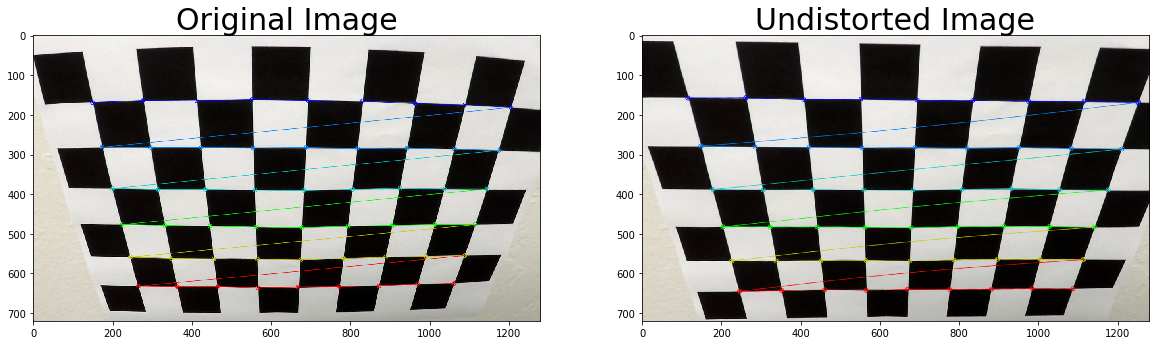

In [3]:
import pickle
%matplotlib inline

# Test undistortion on an image
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('output_images/undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "output_images/wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

### Pipeline (single images)

The pipeline will be organsied as follow: 
`process_image` is the overall pipeline function that will be used process the video.

Please note, the below cell have dependency on the 6 sections which contain the implementation detail of the functions.

In [13]:
src = np.float32(
    [[(img_size[0] / 2) - 60, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 65), img_size[1] / 2 + 100]])
dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])

def process_image(input_image):
    # Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
    
    # Apply a distortion correction to raw images.
    undist_img = undistort(input_image)
    
    # Use color transforms, gradients, etc., to create a thresholded binary image.
    threshold_binary_image_tmp = threshold_binary(undist_img)

    # Apply a perspective transform to rectify binary image ("birds-eye view").
    perspective_transform_image_tmp = perspective_transform(threshold_binary_image_tmp, src, dst)
    
    # Detect lane pixels and fit to find the lane boundary.
    left_fitx_tmp, right_fitx_tmp, ploty_tmp = prepare_for_plot(perspective_transform_image_tmp)
    
    # Determine the curvature of the lane and vehicle position with respect to center.
    labeledImage = curvature(undist_img, left_fitx_tmp, right_fitx_tmp, ploty_tmp)
    
    # Warp the detected lane boundaries back onto the original image.
    Minv_tmp = cv2.getPerspectiveTransform(dst, src)
    processed_image = draw_green_line(perspective_transform_image_tmp, undist_img, Minv_tmp, left_fitx_tmp, right_fitx_tmp, ploty_tmp)
    
    # Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
    
    return processed_image

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = []  
        #y values for detected line pixels
        self.ally = []
        
    def store_Line_info(numberOfAveragedIteration, new_fit, allx, ally):
        self.diffs = new_fit - self.current_fit
        self.current_fit = new_fit
        self.recent_xfitted.append(new_fit)
        self.allx.append(allx)
        self.ally.append(ally)
        averagedX = np.concatenate(allx[-numberOfAveragedIteration:])
        averagedY = np.concatenate(ally[-numberOfAveragedIteration:])
        best_fit = np.polyfit(averagedY, averagedX, 2)
        self.best_fit = best_fit

# laneImage = mpimg.imread('./test_images/sampleTest.jpg')
# leftLane = Line()
# rightLane = Line()
laneImage = mpimg.imread('./test_images/test1.jpg')
processedImage = process_image(laneImage)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(laneImage)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(processedImage)
ax2.set_title('Pipe Line Result Image', fontsize=30)

TypeError: 'NoneType' object is not subscriptable

#### 1. Provide an example of a distortion-corrected image.
To demonstrate this step, I will read the stored camera calibration from previous step, and then apply the correction to one of the test images like this one:

In [14]:
def undistort(image):
    with open("output_images/wide_dist_pickle.p", mode='rb') as f:
        dist_pickle = pickle.load(f)

    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    return undist

True

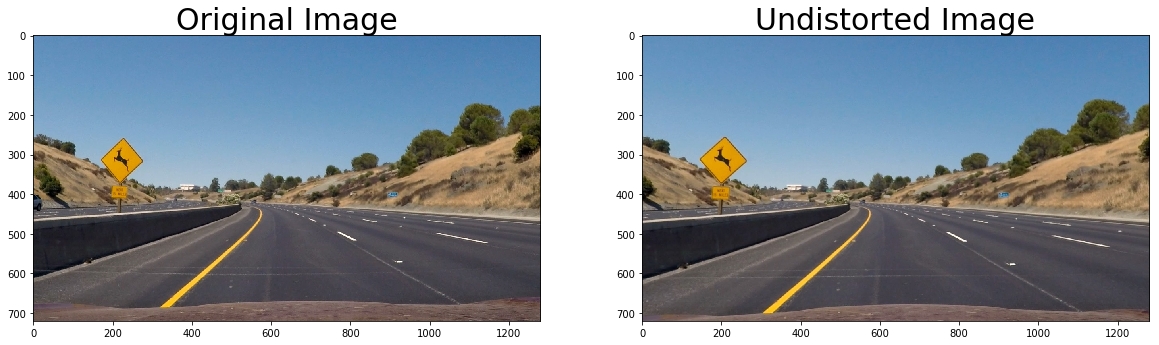

In [15]:
# laneImage = mpimg.imread('./test_images/sampleTest.jpg')
laneImage = mpimg.imread('./test_images/test2.jpg')

undistortImage = undistort(laneImage)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(laneImage)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistortImage)
ax2.set_title('Undistorted Image', fontsize=30)

laneImage_undistort = cv2.cvtColor(undistortImage, cv2.COLOR_BGR2RGB)
cv2.imwrite('output_images/undist_laneImage.jpg', laneImage_undistort)

#### 2. Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image.  Provide an example of a binary image result.
I used a combination of color and gradient thresholds to generate a binary image (thresholding steps at below cell).

In [16]:
# Improve the threshold binary algorithm

def threshold_binary(img):
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = s_channel

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    # Threshold color channel
    s_thresh_min = 175
    s_thresh_max = 250
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary

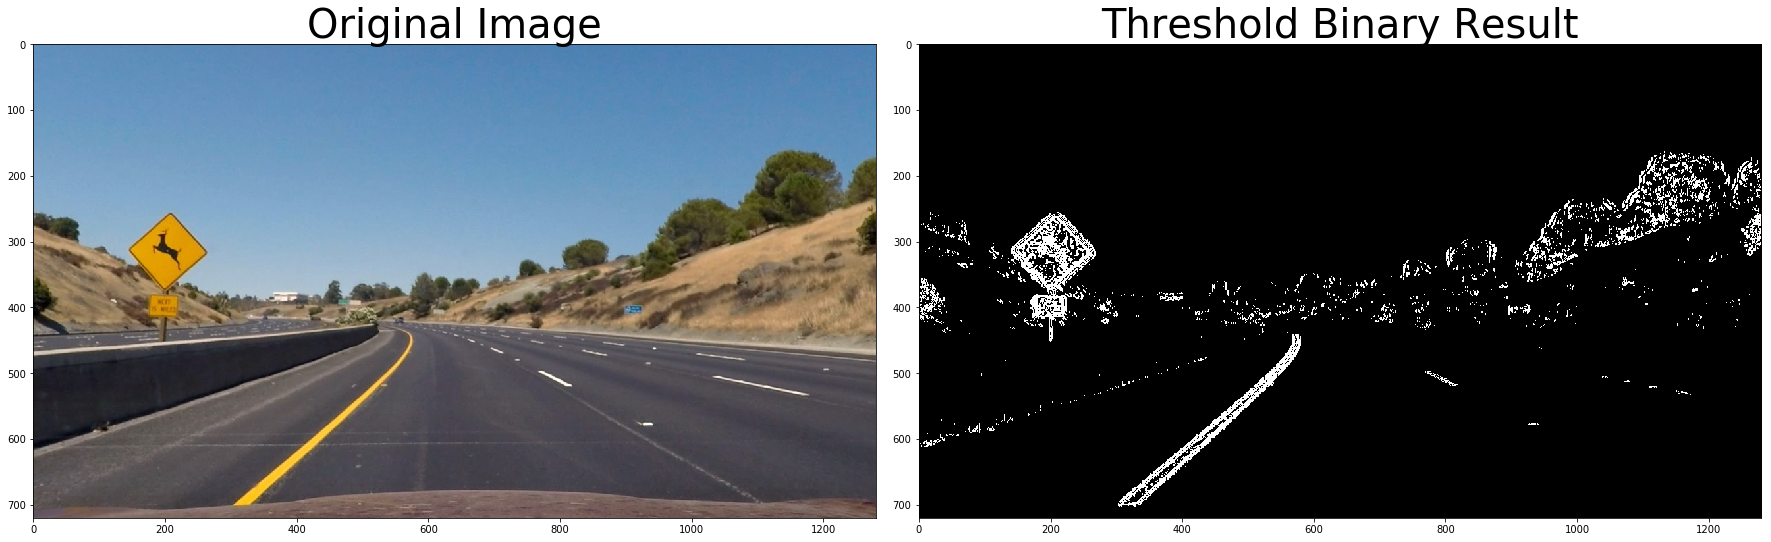

In [17]:
    
threshold_binary_image = threshold_binary(laneImage_undistort)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(undistortImage)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(threshold_binary_image, cmap='gray')
ax2.set_title('Threshold Binary Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


#### 3. Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

The code for my perspective transform includes a function called `perspective_transform()` in the below cell. The `perspective_transform()` function takes as inputs an image (`img`), as well as source (`src`) and destination (`dst`) points.  I chose the hardcode the source and destination points in the following manner:

```
src = np.float32(
    [[(img_size[0] / 2) - 60, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 60), img_size[1] / 2 + 100]])
dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])

```
This resulted in the following source and destination points:

| Source        | Destination   | 
|:-------------:|:-------------:| 
| 580, 460      | 320, 0        | 
| 203, 720      | 320, 720      |
| 1127, 720     | 960, 720      |
| 705, 460      | 960, 0        |

I verified that my perspective transform was working as expected by drawing the `src` and `dst` points onto a test image and its warped counterpart to verify that the lines appear parallel in the warped image.


In [18]:
def perspective_transform(image, src, dst):
    img_size = (image.shape[1], image.shape[0])

    # Compute the perspective transform, M
    M = cv2.getPerspectiveTransform(src, dst)

    # Crate warped image - users liner interpolation
    return cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)

In [19]:
perspective_transformed_image = perspective_transform(threshold_binary_image, src, dst)

# color_threshold_binary = np.dstack((threshold_binary_image, threshold_binary_image, threshold_binary_image))*255


# cv2.line(color_threshold_binary, (580, 460), (203, 720), (255, 0, 0))
# cv2.line(color_threshold_binary, (580, 460), (705, 460), (255, 0, 0))
# cv2.line(color_threshold_binary, (1127, 720), (705, 460), (255, 0, 0))

# # Get perspective transform
# perspective_transformed_image = perspective_transform(color_threshold_binary, src, dst)

# # Visulize undistortion
# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# ax1.set_title('Source image')
# ax1.imshow(color_threshold_binary)
# ax2.set_title('Warped_image')
# ax2.imshow(perspective_transformed_image)

#### 4. Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?

Then I calculated the pixel histogram, find the spike and find a 2nd order polynomial kinda like this:


In [58]:
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def prepare_for_plot(binary_warped):
    if leftLane.detected == False or rightLane.detected == False:
        return prepare_for_plot_new(binary_warped)
    else:
        return prepare_for_plot_detected(binary_warped)
        
def prepare_for_plot_new(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    window_centroids = []
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    leftLane.detected = True if left_lane_inds.size > 0 else False
    rightLane.detected = True if right_lane_inds.size > 0 else False
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Check parallel
    if leftLane.detected == True and rightLane.detected == True:
        distanceArray = np.asarray(right_fitx) - np.asarray(left_fitx)
        distance_difference = max(distanceArray) - min(distanceArray)
        if (min(distanceArray) < 400.0) | (max(distanceArray) > 800.0):
            leftLane.detected = False
            rightLane.detected = False
    
    numberOfAveragedIteration = 5
    
    # Store detected left lane
    if leftLane.detected == True:
        leftLane.diffs = left_fit - leftLane.current_fit
        leftLane.current_fit = left_fit
        leftLane.recent_xfitted.append(left_fit)
        leftLane.allx.append(leftx)
        leftLane.ally.append(lefty)
        averagedLeftx = np.concatenate(leftLane.allx[-numberOfAveragedIteration:])
        averagedLefty = np.concatenate(leftLane.ally[-numberOfAveragedIteration:])
        best_fit = np.polyfit(averagedLefty, averagedLeftx, 2)
        leftLane.best_fit = best_fit
        
    # Store detected right lane
    if rightLane.detected == True:
        rightLane.diffs = right_fit - rightLane.current_fit
        rightLane.current_fit = right_fit
        rightLane.recent_xfitted.append(right_fit)
        rightLane.allx.append(rightx)
        rightLane.ally.append(righty)
        averagedRightx = np.concatenate(rightLane.allx[-numberOfAveragedIteration:])
        averagedRighty = np.concatenate(rightLane.ally[-numberOfAveragedIteration:])
        best_fit = np.polyfit(averagedRighty, averagedRightx, 2)
        rightLane.best_fit = best_fit

    left_fit = leftLane.best_fit if leftLane.best_fit != None  else rifht_fit
    right_fit = rightLane.best_fit if rightLane.best_fit != None else right_fit
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    return left_fitx, right_fitx, ploty

def prepare_for_plot_detected(binary_warped):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    
    left_fit = leftLane.best_fit
    right_fit = rightLane.best_fit
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    leftLane.detected = True if left_lane_inds.size > 0 else False
    rightLane.detected = True if right_lane_inds.size > 0 else Flase
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Check parallel
    if leftLane.detected == True and rightLane.detected == True:
        distanceArray = np.asarray(right_fitx) - np.asarray(left_fitx)
        distance_difference = max(distanceArray) - min(distanceArray)
        if (min(distanceArray) < 400.0) | (max(distanceArray) > 800.0):
            leftLane.detected = False
            rightLane.detected = False
    
    numberOfAveragedIteration = 5
    
    if leftLane.detected == True:
        leftLane.diffs = left_fit - leftLane.current_fit
        leftLane.current_fit = left_fit
        leftLane.recent_xfitted.append(left_fit)
        leftLane.allx.append(leftx)
        leftLane.ally.append(lefty)
        averagedLeftx = np.concatenate(leftLane.allx[-numberOfAveragedIteration:])
        averagedLefty = np.concatenate(leftLane.ally[-numberOfAveragedIteration:])
        best_fit = np.polyfit(averagedLefty, averagedLeftx, 2)
        leftLane.best_fit = best_fit
        
    # Store detected right lane
    if rightLane.detected == True:
        rightLane.diffs = right_fit - rightLane.current_fit
        rightLane.current_fit = right_fit
        rightLane.recent_xfitted.append(right_fit)
        rightLane.allx.append(rightx)
        rightLane.ally.append(righty)
        averagedRightx = np.concatenate(rightLane.allx[-numberOfAveragedIteration:])
        averagedRighty = np.concatenate(rightLane.ally[-numberOfAveragedIteration:])
        best_fit = np.polyfit(averagedRighty, averagedRightx, 2)
        rightLane.best_fit = best_fit

    left_fit = leftLane.best_fit if leftLane.best_fit != None  else rifht_fit
    right_fit = rightLane.best_fit if rightLane.best_fit != None else right_fit
    
    left_fit = leftLane.best_fit if leftLane.best_fit != None  else rifht_fit
    right_fit = rightLane.best_fit if rightLane.best_fit != None else right_fit
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

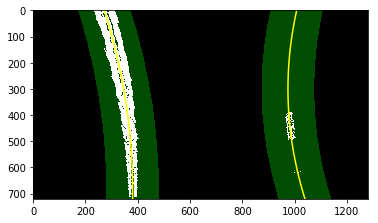

In [59]:
def display_plot(binary_warped, left_fitx, right_fitx, ploty):
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

leftLane = Line()
rightLane = Line()
left_fitx, right_fitx, ploty = prepare_for_plot(perspective_transformed_image)
display_plot(perspective_transformed_image, left_fitx, right_fitx, ploty)

#### 5. Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

After I got the points on the line, then I use `curvature()` to calculte the curvature of the lane

In [60]:
def curvature(image, leftx, rightx, ploty):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = np.max(ploty)
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    
    if ((left_curverad > 100.) & (left_curverad < 10000.)) & ((right_curverad > 100.) & (right_curverad < 10000.)):
        leftLane.radius_of_curvature = left_curverad
        rightLane.radius_of_curvature = right_curverad
    else:
        left_curverad = left_curverad if leftLane.radius_of_curvature == None else leftLane.radius_of_curvature
        right_curverad = right_curverad if rightLane.radius_of_curvature == None else rightLane.radius_of_curvature
        leftx = leftx if leftLane.recent_xfitted == None else leftLane.recent_xfitted
        rightx = rightx if rightLane.recent_xfitted == None else rightLane.recent_xfitted

    font = cv2.FONT_HERSHEY_SIMPLEX
    offcenterDistance = (leftx[0] + rightx[0] - image.shape[1]) * xm_per_pix / 2.0
    offcenterDistance = 0 if offcenterDistance.size > 1 else offcenterDistance
    sideOfLane = "right" if offcenterDistance > 0 else "left"
    offcenterText = "Vehicle is {:.2f} m {} of center".format(abs(offcenterDistance), sideOfLane)

    labeledImage = cv2.putText(image, offcenterText, (10, 200), font, 2, (255, 255, 255), 2, cv2.LINE_AA)
    
    curvatureText = "Radius of Curvature = {:.0f}(m)".format((left_curverad + right_curverad) / 2.0)
    labeledImage = cv2.putText(image, curvatureText,(10, 100), font, 2,(255,255,255),2,cv2.LINE_AA)
    
    return labeledImage


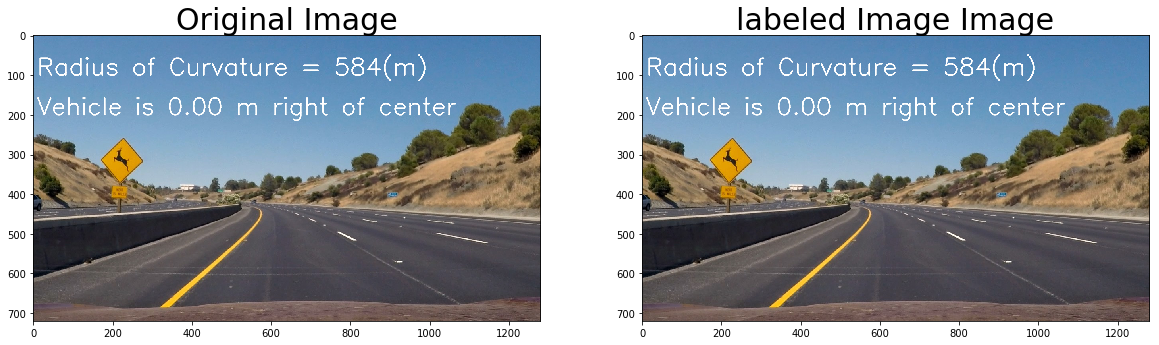

In [61]:
labeledImage = curvature(laneImage, left_fitx, right_fitx, ploty)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(laneImage)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(labeledImage)
ax2.set_title('labeled Image Image', fontsize=30)

# Example values: 632.1 m    626.2 m

#### 6. Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.

I use `draw_green_line()` to plot back the previous step on the image.  Here is an example of my result on a test image:

In [62]:
def draw_green_line(warped, undist, Minv, left_fitx, right_fitx, ploty):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    return result

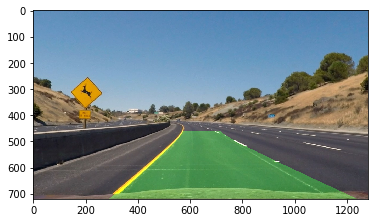

In [63]:
Minv = cv2.getPerspectiveTransform(dst, src)
result = draw_green_line(perspective_transformed_image, undistortImage, Minv, left_fitx, right_fitx, ploty)
plt.imshow(result)

### Pipeline (video)

#### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!).

Here's a [link to my video result](./project_video.mp4)

In [64]:
pipe_line_output = "pipeLineOutput.mp4"
clip1 = VideoFileClip("project_video.mp4")
leftLane = Line()
rightLane = Line()
pipe_line_output_clip = clip1.fl_image(process_image)
%time pipe_line_output_clip.write_videofile(pipe_line_output, audio=False)



[MoviePy] >>>> Building video pipeLineOutput.mp4
[MoviePy] Writing video pipeLineOutput.mp4




  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:00<02:31,  8.29it/s]

  0%|          | 2/1261 [00:00<02:32,  8.25it/s]

  0%|          | 3/1261 [00:00<02:38,  7.95it/s]

  0%|          | 4/1261 [00:00<02:45,  7.62it/s]

  0%|          | 5/1261 [00:00<02:49,  7.39it/s]

  0%|          | 6/1261 [00:00<02:53,  7.25it/s]

  1%|          | 7/1261 [00:00<02:53,  7.21it/s]

  1%|          | 8/1261 [00:01<02:55,  7.12it/s]

  1%|          | 9/1261 [00:01<02:54,  7.16it/s]

  1%|          | 10/1261 [00:01<02:55,  7.12it/s]

  1%|          | 11/1261 [00:01<02:54,  7.17it/s]

  1%|          | 12/1261 [00:01<02:55,  7.11it/s]

  1%|          | 13/1261 [00:01<02:53,  7.21it/s]

  1%|          | 14/1261 [00:01<02:58,  7.00it/s]

  1%|          | 15/1261 [00:02<03:01,  6.88it/s]

  1%|▏         | 16/1261 [00:02<03:03,  6.80it/s]

  1%|▏         | 17/1261 [00:02<03:02,  6.81it/s]

  1%|▏         | 18/1261 [00:02<03:16,  6.33it/s]

  2%|▏         | 19/1261 [00:02<03:27,  6.00it/

[MoviePy] Done.
[MoviePy] >>>> Video ready: pipeLineOutput.mp4 

CPU times: user 3min 58s, sys: 47.2 s, total: 4min 45s
Wall time: 3min 17s


### Discussion

#### 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

The project code would perform well on high way, where the lane line is clearly visible and road curvature is aroudn 1K.

* If a lane detection fail, it will assume the road structure would be similar to last know structure as this is part of the sanity check
* It will not perform well on road with sharp turn.(i.e. Harder Challenge Video Condition) 
* the area of interest defined in the project 4 does not fit real life curvry road well (i.e. Harder Challenge Video Condition)

The project are making assumption that the lane area should be roughly with in the cropped window area. And we also storing for previous detected lane to further enhance this feature.

To improve the performance of lane detection, we could fine tune the hyper parameter for color space thresholding. On top of that, we could further improve sanity check to eliminate false positive result on passing cars.
